# Interactive Visualization

One of the nice things about python is that sometimes, prototyping is easy.

The following example is not optimzed at all, but it might serve you as a starting point for doing something much more nice.

Most of the sutff is hardcoded, but you can easily enginner the `Visualizer` class to improve it.

The idea is to run an interactive visualization with `Open3D` and modify some parameters of the segmentation algorithm while having direct feedback on your modification. Depending on how much time the segmentation task takes, this might get "laggy". You can change multiple stuff at the same time, and go really wild, but for now let's start by chaning 1 parameter `distance_threshold`

In [1]:
from functools import partial
import IPython.display
import numpy as np
import PIL.Image
import open3d as o3d

In [2]:
class Visualizer:
    def __init__(self, pcd, step=0.01):
        self.pcd = pcd
        self.geometries = []
        self.distance_threshold = 0.1
        self.ransac_n = 3
        self.num_iterations = 100
        self.step = step

        # Visualizer
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window()
        self.render_options = self.vis.get_render_option()
        self.view_control = self.vis.get_view_control()

        # Initialize the default callbacks
        self._register_key_callbacks()
        self._print_help()

        # Initialize the Visualizer
        self._segment_point_cloud()
        self._initialize_visualizer()
        self._set_viewpoint()

    def _initialize_visualizer(self):
        for geom in self.geometries:
            self.vis.add_geometry(geom, reset_bounding_box=True)

    def less(self, vis):
        self.distance_threshold -= self.step
        print("Setting distance threshold to #{:.3f}".format(
            self.distance_threshold), end="\r")
        self._segment_point_cloud()
        self._update_geometries()
        return False

    def more(self, vis):
        self.distance_threshold += self.step
        print("Setting distance threshold to #{:.3f}".format(
            self.distance_threshold), end="\r")
        self._segment_point_cloud()
        self._update_geometries()
        return False

    def _update_geometries(self):
        self.vis.clear_geometries()
        for geom in self.geometries:
            self.vis.add_geometry(geom, reset_bounding_box=False)
        self.vis.poll_events()
        self.vis.update_renderer()

    def _set_viewpoint(self):
        self.view_control.set_lookat([2.53, 1.12, -5.31])
        self.view_control.set_up([0.49, 0.05, 0.87])
        self.view_control.set_front([-0.86, -0.13, 0.49])
        self.view_control.set_zoom(0.1)

    def register_key_callback(self, key, callback):
        self.vis.register_key_callback(ord(str(key)), partial(callback))

    def _register_key_callbacks(self):
        self.register_key_callback("=", self.more)  # means "+"
        self.register_key_callback("-", self.less)

    def _segment_point_cloud(self):
        self.geometries.clear()
        _, plane_points = self.pcd.segment_plane(
            distance_threshold=self.distance_threshold,
            ransac_n=self.ransac_n,
            num_iterations=self.num_iterations)

        plane_cloud = pcd.select_by_index(plane_points)
        plane_cloud.paint_uniform_color([1, 0, 0])

        rest_cloud = pcd.select_by_index(plane_points, invert=True)
        rest_cloud.paint_uniform_color([0, 0, 1])
        self.geometries = [plane_cloud, rest_cloud]

    def set_render_options(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self.render_options, key, value)

    @staticmethod
    def _print_help():
        print("+: Increase Distance Threshold")
        print("-: Decrease Distance Threshold")
        print("Q: quit")

    def run(self):
        self.vis.run()
        self.stop()

    def stop(self):
        print("\nFinal parameters:")
        print("distance_threshold =", self.distance_threshold)
        print("ransac_n =", self.ransac_n)
        print("num_iterations =", self.num_iterations)

        # Capture the image and display it in the jupyter notebook
        im = self.vis.capture_screen_float_buffer()
        self.vis.destroy_window()
        im = PIL.Image.fromarray(
            (255 * np.asarray(im)).astype(np.uint8), "RGB")
        IPython.display.display(im)

## Main application

Create an instance of the visualizer app and have fun with it!

+: Increase Distance Threshold
-: Decrease Distance Threshold
Q: quit
Setting distance threshold to #0.500
Final parameters:
distance_threshol = 0.5000000000000003
ransac_ = 3
num_iteration = 100


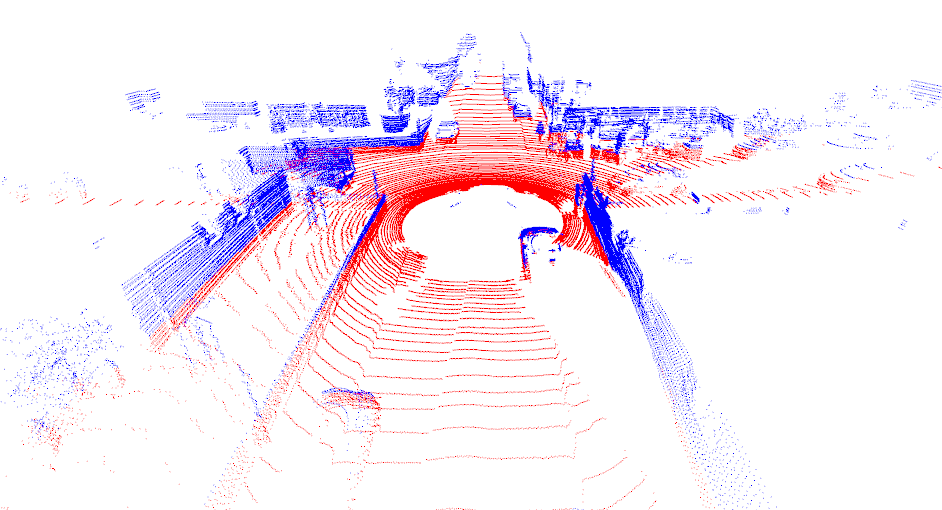

In [3]:
pcd = o3d.io.read_point_cloud('./kitti_seq_07_scan_000000.ply')
vis = Visualizer(pcd)
vis.set_render_options(point_size=1)
vis.run()